In [2]:
#Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from ThymeBoost import ThymeBoost as tb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.holtwinters import Holt
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Importing the Data
df_covid = pd.read_csv('/Users/omkarsadekar/Documents/NEU Study Material/NEU Study Material/Healthcare Data and Applications/Time_Series_Forecasting_Covid19/Data/covid_mass_df_cleaned.csv')
df_covid.head(5)

,Week Start Date,Week End Date,Group,Subgroup,Estimated population,Percent of the population,Cases during this week,Week case rate,Cumulative cases,Cumulative case rate,Deaths during this week,Week death rate,Cumulative deaths,Cumulative death rate,Confirmed deaths,Confirmed cases
0,2023-07-02,2023-07-08,Race and Hispanic ethnicity,"Hispanic, all races",878944.174599,0.125029,131,14.904246,131.0,14.904246,0,0.000000,0,0.000000,7.0,607.0
1,2023-07-02,2023-07-08,Race and Hispanic ethnicity,"Asian, not Hispanic",510096.110667,0.072561,29,5.685203,29.0,5.685203,1,0.196041,1,0.196041,7.0,607.0
2,2023-07-02,2023-07-08,Race and Hispanic ethnicity,"Black or African-American, not Hispanic",476930.244828,0.067843,53,11.112736,53.0,11.112736,0,0.000000,0,0.000000,7.0,607.0
3,2023-07-02,2023-07-08,Race and Hispanic ethnicity,"Alaskan Native or American Indian, not Hispanic",9939.379615,0.001414,0,0.000000,0.0,0.000000,0,0.000000,0,0.000000,7.0,607.0
4,2023-07-02,2023-07-08,Race and Hispanic ethnicity,"Other race, not Hispanic",0.000000,0.000000,23,0.000000,23.0,0.000000,1,0.000000,1,0.000000,7.0,607.0


In [4]:
#Handling Data Types
import pandas as pd

# date columns to datetime
date_columns = ['Week Start Date', 'Week End Date']
df_covid[date_columns] = df_covid[date_columns].apply(pd.to_datetime)

In [5]:
# Selecting the required columns
df_forecast = df_covid[['Week Start Date', 'Week End Date', 'Cases during this week','Deaths during this week']]
df_forecast.head(5)

,Week Start Date,Week End Date,Cases during this week,Deaths during this week
0,2023-07-02,2023-07-08,131,0
1,2023-07-02,2023-07-08,29,1
2,2023-07-02,2023-07-08,53,0
3,2023-07-02,2023-07-08,0,0
4,2023-07-02,2023-07-08,23,1


In [6]:
# Replace values 1-4 with 2 in the 'Cases during this week' column
df_forecast['Deaths during this week'] = df_forecast['Deaths during this week'].replace(["1-4"], 2)
# Convert 'Cases during this week' column to float
df_forecast['Deaths during this week'] = df_forecast['Deaths during this week'].astype(float)

# Replace values 1-4 with 2 in the 'Cases during this week' column
df_forecast['Cases during this week'] = df_forecast['Cases during this week'].replace(["1-4"], 2)
# Convert 'Cases during this week' column to float
df_forecast['Cases during this week'] = df_forecast['Cases during this week'].astype(float)

In [7]:
trend_data = df_forecast.groupby('Week Start Date').agg({
    'Cases during this week': 'sum',
    'Deaths during this week': 'sum'
}).reset_index()
trend_data.head(5)

,Week Start Date,Cases during this week,Deaths during this week
0,2023-07-02,2538.0,24.0
1,2023-07-09,2916.0,24.0
2,2023-07-16,3440.0,28.0
3,2023-07-23,4468.0,21.0
4,2023-07-30,5216.0,6.0


In [8]:
#Creating datetime object with date 25th January, 2020 and storing it in variable x.
x = datetime.datetime(2023,7,2)
#Subtracting x from dates stored in date column of data frame and storing the result in new column 'days'.
#Inserting column 'days' as first column. 
trend_data.insert(0,'Days','')
trend_data['Days'] = (trend_data['Week Start Date']-x).dt.days
#Print Data frame df
trend_data

,Days,Week Start Date,Cases during this week,Deaths during this week
0,0,2023-07-02,2538.0,24.0
1,7,2023-07-09,2916.0,24.0
2,14,2023-07-16,3440.0,28.0
3,21,2023-07-23,4468.0,21.0
4,28,2023-07-30,5216.0,6.0
5,35,2023-08-06,7075.0,63.0
6,42,2023-08-13,7725.0,48.0
7,49,2023-08-20,9029.0,57.0
8,56,2023-08-27,10202.0,72.0
9,63,2023-09-03,10705.0,72.0


In [9]:
#numpy arrays : days stores values in days columns of data frame df. 
#cases stores cases values in cases columns of data frame df.
#deaths stores deaths values in deaths columns of data frame df.
days = np.asarray(trend_data['Days'],dtype=int)
cases = np.asarray(trend_data['Cases during this week'],dtype=int)
deaths = np.asarray(trend_data['Deaths during this week'],dtype=int)

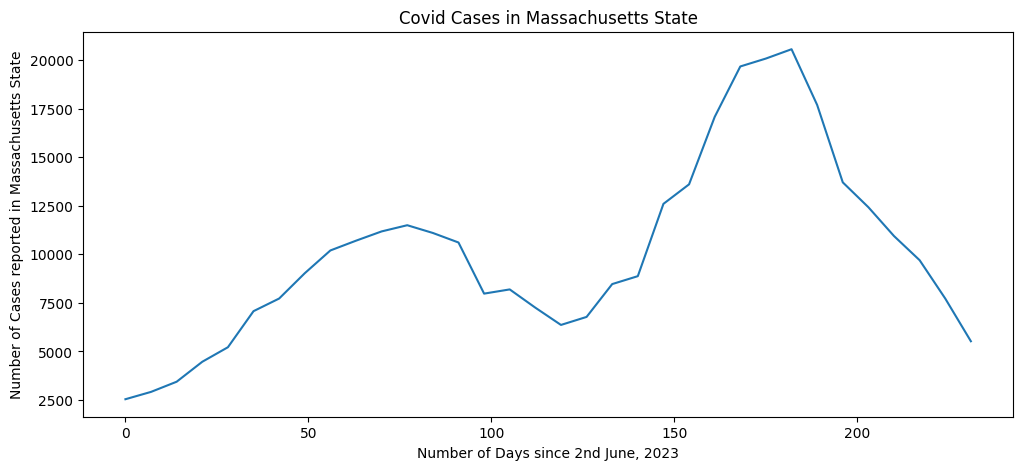

In [10]:
#Plotting Line plot of number of cases vs days
fig=plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(days,cases)
plt.xlabel('Number of Days since 2nd June, 2023')
plt.ylabel('Number of Cases reported in Massachusetts State')
plt.title('Covid Cases in Massachusetts State')
plt.show()

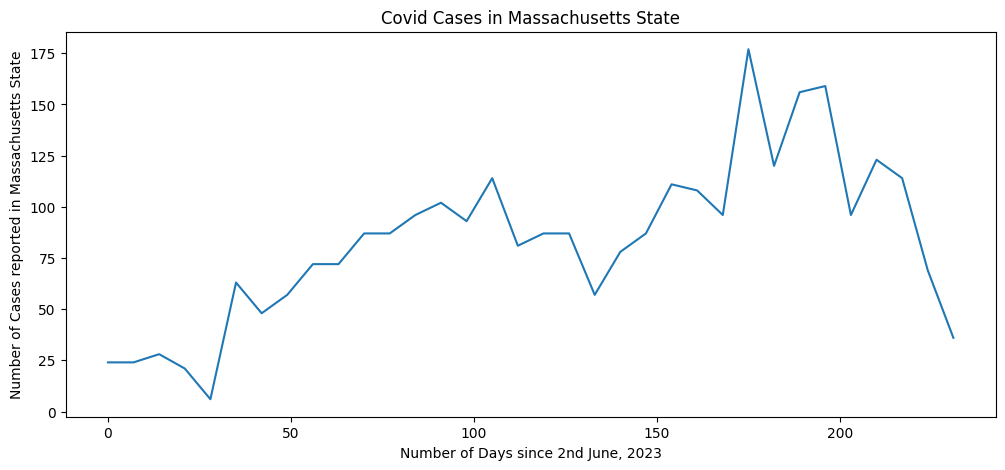

In [11]:
#Plotting Line plot of number of deaths vs days
fig=plt.figure(figsize=(12,5),dpi= 100,facecolor='w',edgecolor='k')
plt.plot(days,deaths)
plt.xlabel('Number of Days since 2nd June, 2023')
plt.ylabel('Number of Cases reported in Massachusetts State')
plt.title('Covid Cases in Massachusetts State')
plt.show()

In [12]:
import numpy as np

def forecast_accuracy(forecast, actual):
    # Convert forecast and actual to numpy arrays
    forecast = np.array(forecast)
    actual = np.array(actual)
    
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual + 1))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / (actual + 1))   # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)             # minmax
    return {'mape': mape, 'me': me, 'mae': mae, 'mpe': mpe, 'rmse': rmse, 'corr': corr, 'minmax': minmax}


In [13]:
#adfuller is used for ADF Test.
result = adfuller(trend_data['Cases during this week'])
print('ADF Statistic: ',result[0])
print('p-value: %f',result[1])

ADF Statistic:  -0.8502264968191692
p-value: %f 0.8039215973165736


In [14]:
#Fitting ARIMA model
model = SARIMAX(trend_data['Cases during this week'],order=(6,0,2))  #order = (p,d,q)
model_fit = model.fit(disp=0)
# Forecasting for the next 4 weeks
fc = model_fit.forecast(steps=4)  # Forecast for 6 weeks

In [15]:
# Generating dates for the forecasted period
curr_date = pd.to_datetime(trend_data['Week Start Date'].iloc[-1])
forecast_dates = [curr_date + timedelta(days=(7 * i)) for i in range(1, 5)]

# Creating DataFrame for the forecasted results
res_dates = pd.DataFrame(data=forecast_dates, columns=['Week Start Date'])
res_cases = pd.DataFrame(data=fc.values, columns=['Cases during this week'])
res_df = pd.concat([res_dates, res_cases], axis=1)

print(res_df)

  Week Start Date  Cases during this week
0      2024-02-25             4695.155812
1      2024-03-03             3550.115275
2      2024-03-10             2600.034644
3      2024-03-17             2927.387274


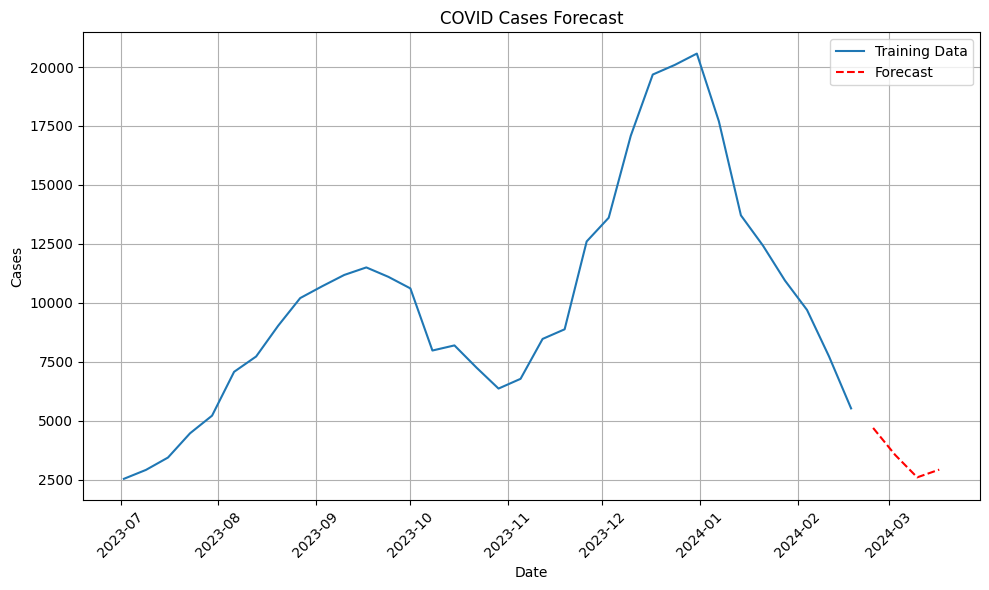

In [16]:
# Plotting the forecasted results
plt.figure(figsize=(10, 6))
plt.plot(trend_data['Week Start Date'], trend_data['Cases during this week'], label='Training Data')
plt.plot(res_df['Week Start Date'], res_df['Cases during this week'], label='Forecast', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID Cases Forecast')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Create train and test sets
train = trend_data['Cases during this week'][:-4]  # Exclude last 4 weeks for testing
test = trend_data['Cases during this week'][-4:]  # Last 4 weeks for testing

# Fitting SARIMAX model on train set
model = SARIMAX(train, order=(6, 0, 2))
model_fit = model.fit(disp=0)

# Forecasting for the next 4 weeks
fc = model_fit.forecast(steps=4)

# Evaluating forecast accuracy
accuracy_metrics = forecast_accuracy(fc, test.values)

# Display accuracy metrics
print("Forecast Accuracy Metrics:")
print(accuracy_metrics)


Forecast Accuracy Metrics:
{'mape': 0.20001659645630276, 'me': -1452.2034518625549, 'mae': 1813.6032356836802, 'mpe': -0.13460487087781853, 'rmse': 2028.0184131021535, 'corr': 0.9579982392537951, 'minmax': 0.1962549713110775}


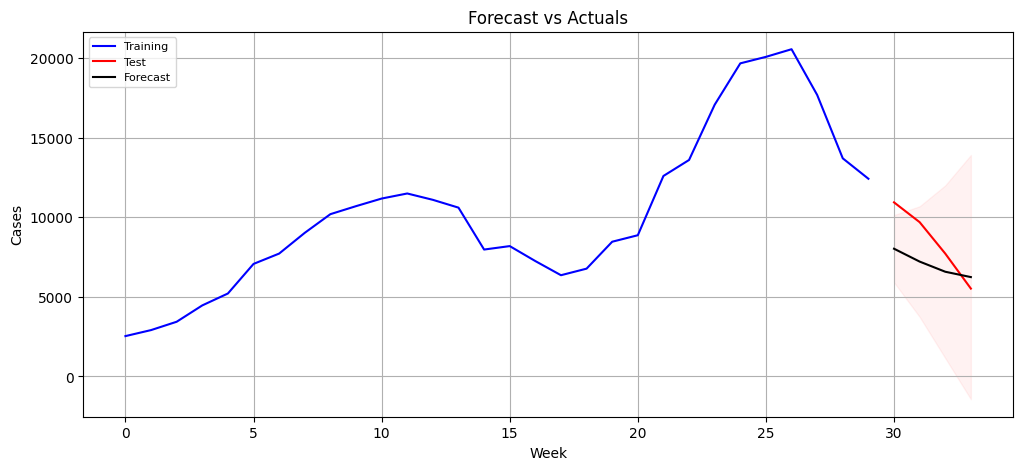

In [18]:
# Plotting training, test, and forecast
fcast = model_fit.get_forecast(4)  # Forecast for 4 weeks
conf = fcast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:, 0], index=conf.index)
upper_series = pd.Series(conf.iloc[:, 1], index=conf.index)
fc_series = pd.Series(fc, index=fc.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='Training', c='b')
plt.plot(test, label='Test', c='r')
plt.plot(fc_series, label='Forecast', c='k')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.05)
plt.legend(loc='upper left', fontsize=8)
plt.title('Forecast vs Actuals')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.grid(True)
plt.show()


In [20]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(trend_data["Cases during this week"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [22]:
#Summarizing the model
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(1, 2, 0)x(1, 1, 0, 12)   Log Likelihood                -177.822
Date:                            Sun, 31 Mar 2024   AIC                            361.644
Time:                                    15:53:09   BIC                            364.632
Sample:                                         0   HQIC                           362.227
                                             - 34                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4181      0.212     -1.972      0.049      -0.834      -0.002
ar.S.L12      -0.8299      0.362   

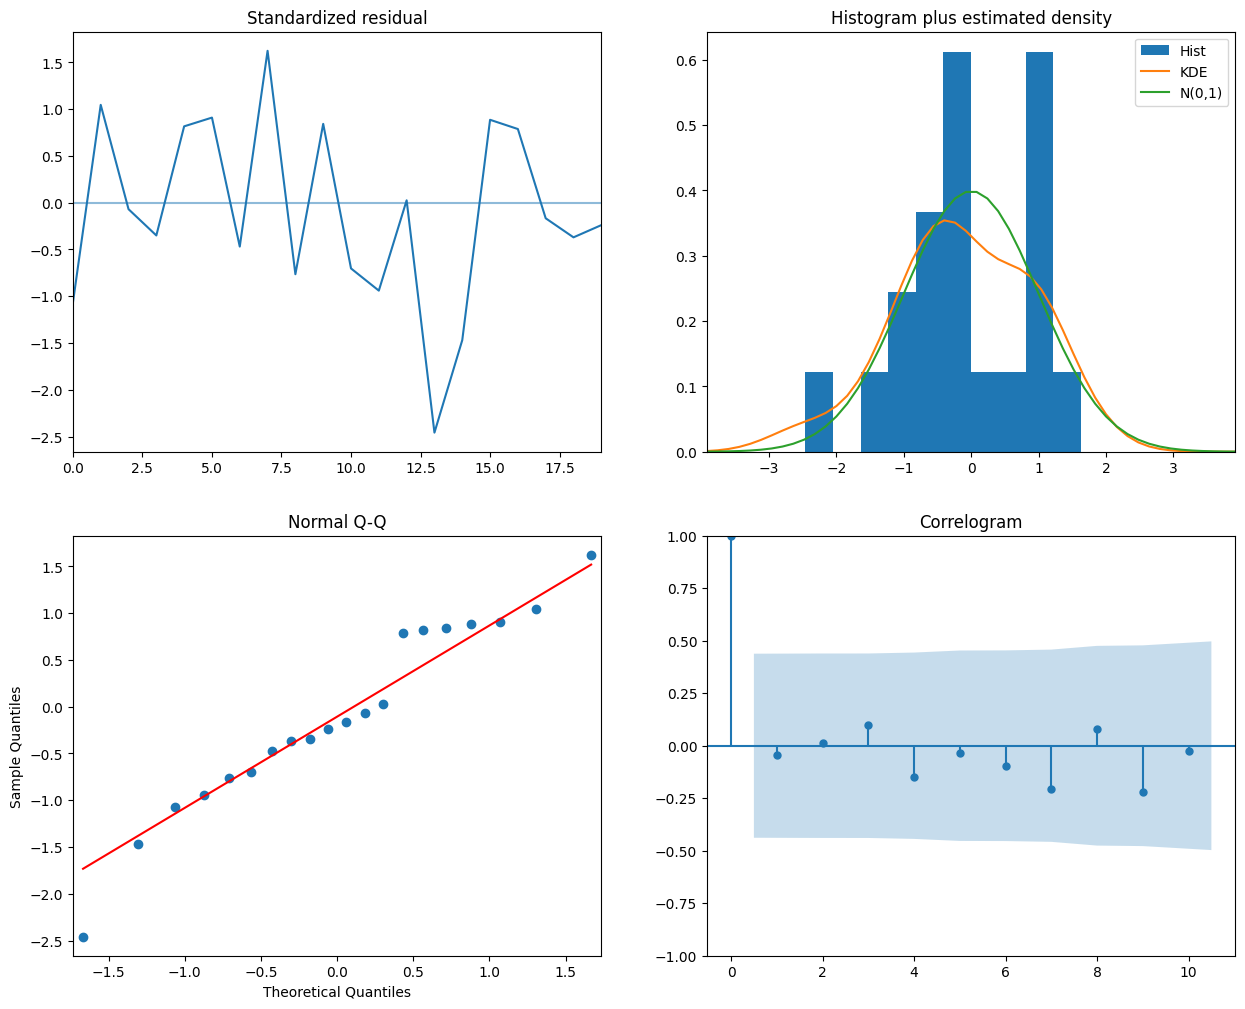

In [23]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()